In [1]:
import sys
sys.path.append('../libs')


In [2]:
import numpy as np
import pandas as pd
import data_lib, plot_lib, decision_lib, validation_lib, transform_lib
from sklearn import cluster, mixture

np.random.seed(200)

In [3]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [4]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     #"wa-sa-A2", 
                                     #"wa-sa-B4",
                                     #"wa-sa-C4",
                                     #"wa-sa-B3",  
                                     #"wa-sa-B2",
                                     #"wa-sa-A5", 
                                     "wa-sa-A3",
                                     #"wa-sa-C2",
                                     #"wa-sa-C3", # Pos
                                     #"wa-sa-D3", # Zero
                                     #"wa-sa-D4", 
                                     #"wa-sa-B1", 
                                     #"wa-sa-A4",
                                     #"wa-sa-A1", 
                                     #"wa-sa-D2",
                                     #"wa-sa-C5", # Pos
                                     #"wa-sa-D5", # Zero
                                     #"wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [5]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, n_jobs=4, min_samples=6, leaf_size=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 1.6)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.ClusterRelativeHierarchyMeanClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     eps=0.5,
                                     contamination=0.004,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_wa)

[2 0 3 1 1 4 0 2 0 2 0 0 0 0 2 2 1 0 2 0 0 2 1 2 2 1 2 4 0 1 1 0 0 2 2 2 2
 0 2 0 2 0 0 2 2 0 1 3 2 1 2 1 0 0 0 0 0 0 2 0 2 2 0 0 2 0 0 0 2 0 3 2 2 0
 0 3 3 1 2 2 3 0 2 2 1 1 2 0 2 1 1 1 0 0 3 2 2 1 0 1 2 0 0]


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

In [6]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = decision.predictions_df
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]
mask = decision.No_neg_mask

validation_lib.validate_labels(df_wa, df_decision)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

AttributeError: 'ClusterRelativeHierarchyMeanClassifier' object has no attribute 'probabilies_df'

### Error inspection

print only cluster with missclassifications

ic| cluster: -1, dim:

 'IAV-M_POS', n_cluster - n_true: 6
ic| cluster: 0, dim: 'IAV-M_POS', n_cluster - n_true: 1
ic| cluster: 1, dim: 'IAV-M_POS', n_cluster - n_true: 35
ic| cluster: 2, dim: 'IAV-M_POS', n_cluster - n_true: 2
ic| cluster: 3, dim: 'IAV-M_POS', n_cluster - n_true: 1
ic| cluster: 4, dim: 'IAV-M_POS', n_cluster - n_true: 6
ic| cluster: 5, dim: 'IAV-M_POS', n_cluster - n_true: 6
ic| cluster: 6, dim: 'IAV-M_POS', n_cluster - n_true: 30
ic| cluster: 7, dim: 'IAV-M_POS', n_cluster - n_true: 10
ic| cluster: 8, dim: 'IAV-M_POS', n_cluster - n_true: 1
ic| cluster: 9, dim: 'IAV-M_POS', n_cluster - n_true: 5
ic| cluster: 10, dim: 'IAV-M_POS', n_cluster - n_true: 1
ic| cluster: 11, dim: 'IAV-M_POS', n_cluster - n_true: 48
ic| cluster: 12, dim: 'IAV-M_POS', n_cluster - n_true: 54
ic| cluster: 13, dim: 'IAV-M_POS', n_cluster - n_true: 2
ic| cluster: 14, dim: 'IAV-M_POS', n_cluster - n_true: 3
ic| cluster: 15, dim: 'IAV-M_POS', n_cluster - n_true: 8
ic| cluster: 16, dim: 'IAV-M_POS', n_cluster - n_true: 16

(Partially) falsely classified clusters [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102]


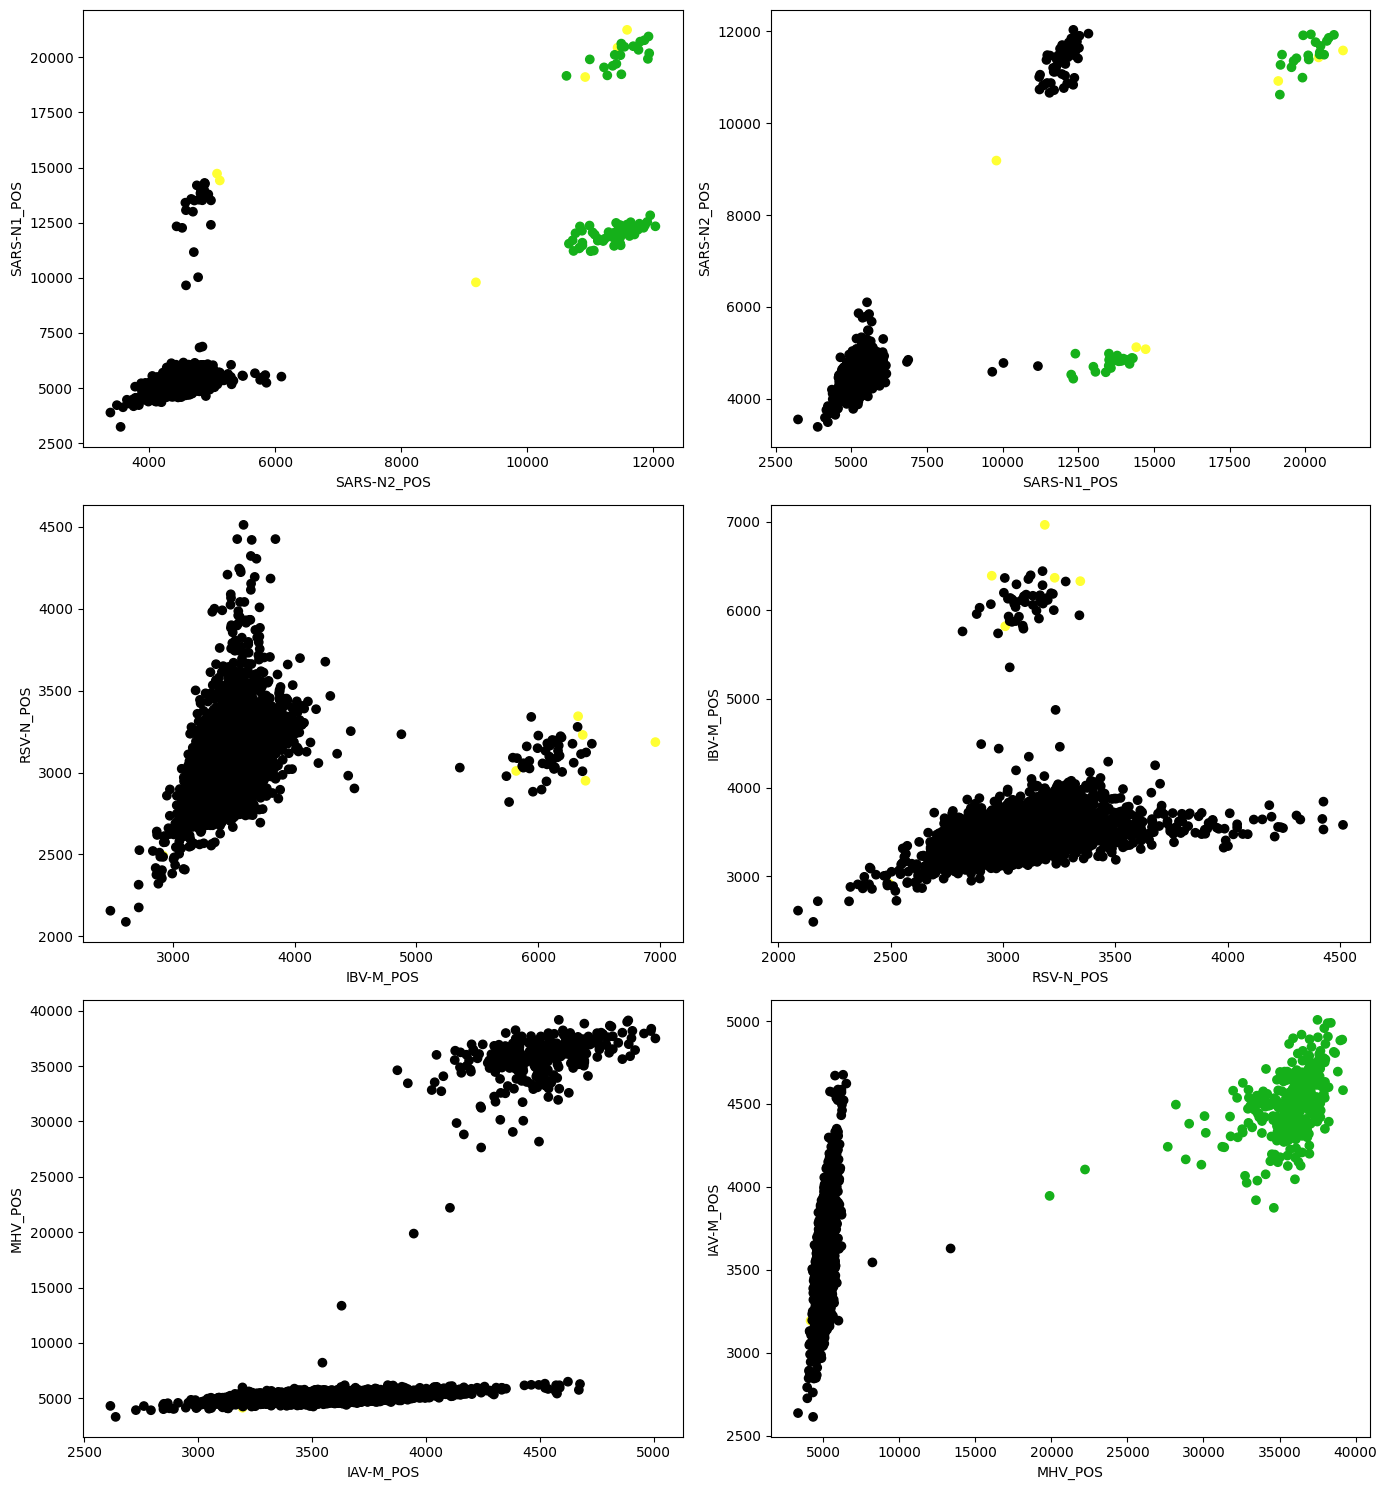

In [ ]:
diseases = ["IAV-M_POS", "MHV_POS", "SARS-N1_POS", "SARS-N2_POS", "IBV-M_POS", "RSV-N_POS"]
false_clusters = validation_lib.get_false_clusters(clusters=decision.cluster_dict,
                                  df_true_labels=df_ground_trouth,
                                  df_predictions=df_predictions,
                                  disease=diseases,
                                  threshold=0.99)
df_false_data, df_false_predictions, df_false_ground_truth = validation_lib.get_false_cluster_for_plotting(df_data_points=df_data_points,
                                                                                                           df_predictions=df_predictions,
                                                                                                           df_ground_truth=df_ground_trouth,
                                                                                                           clusters=decision.cluster_dict,
                                                                                                           false_clusters=false_clusters)
print(f"(Partially) falsely classified clusters {false_clusters}")
plot_lib.plot_pairwise_selection(data_points=df_false_data, selected_pairs=selected_pairs, predictions=df_false_predictions, ground_trouth=df_false_ground_truth)